In [1]:
from google.colab import drive, files
import librosa, librosa.display
import os
import csv, json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET_PATH = '/content/drive/MyDrive/DNN_2022/Project/data/GTZAN/sample.json'

In [4]:
with open(DATASET_PATH) as f: data = json.load(f)
X = np.array(data['mfccs'])
y = np.array(data['labels'])

In [5]:
y_df = pd.Series(y)
labels = dict(zip(y_df.unique(), range(0,10)))
y = y_df.map(labels)
y = y.to_numpy()


In [6]:
print(X.shape)
print(y.shape)
print(labels)

(9980, 13, 130)
(9980,)
{'classical': 0, 'disco': 1, 'jazz': 2, 'reggae': 3, 'rock': 4, 'country': 5, 'hiphop': 6, 'blues': 7, 'pop': 8, 'metal': 9}


In [7]:
labels = ['classical',
 'disco',
 'jazz',
 'reggae',
 'rock',
 'country',
 'hiphop',
 'blues',
 'pop',
 'metal']

print(labels)

['classical', 'disco', 'jazz', 'reggae', 'rock', 'country', 'hiphop', 'blues', 'pop', 'metal']


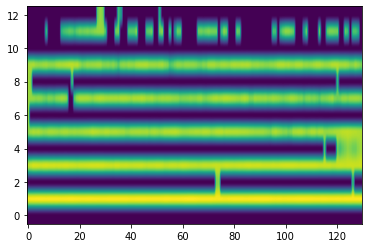

In [8]:
im = plt.imshow(librosa.power_to_db(X[0]), origin="lower", aspect="auto")

## Create the dataset

In [9]:
class GTZANFeatureDataset():

  def __init__(self, x, y):

    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, idx):
    # X = self.x[idx]
    # y = self.y[idx]

    X = torch.tensor([self.x[idx]], dtype=torch.float32)
    # X = self.x[idx]
    y = self.y[idx]

    return X, y

### create train, validation and test datasets.

In [10]:
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.0001

gtzan_dataset = GTZANFeatureDataset(X, y)

def split_percent(dataset, percentage):
  dataset_len = len(dataset)
  train_len = int(percentage * dataset_len)
  val_len = int(dataset_len - train_len)
  return train_len, val_len

train_len, val_len = split_percent(gtzan_dataset, 0.85)
train_dataset, val_dataset = random_split(gtzan_dataset, [train_len, val_len])

val_len, test_len = split_percent(val_dataset, 0.8)
val_dataset, test_dataset = random_split(val_dataset, [val_len, test_len])

print(len(gtzan_dataset))
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

9980
8483
1197
300


In [11]:
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
data_iter = iter(dataloader_train)
inputs, targets = next(data_iter)

<ipython-input-9-1a9f285dd921>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X = torch.tensor([self.x[idx]], dtype=torch.float32)


In [13]:
inputs.shape

torch.Size([256, 1, 13, 130])

In [14]:
targets.shape

torch.Size([256])

## Model

In [15]:
class FeedForward(nn.Module):

  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.dense_layers = nn.Sequential(
        nn.Linear(13*130, 512),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(64, 10)
    )
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_data):
    flattened_data = self.flatten(input_data)
    logits = self.dense_layers(flattened_data)
    predictions = self.softmax(logits)
    return predictions

In [16]:
labels

['classical',
 'disco',
 'jazz',
 'reggae',
 'rock',
 'country',
 'hiphop',
 'blues',
 'pop',
 'metal']

## Training Loop

In [17]:
def train(model, loss_fun, optimiser, device, epochs, train_data_loader, val_data_loader=None):

  start_training_time = time()

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  
  for epoch in range(epochs):
      
    # TRAINING
    running_losses = []
    for inputs, targets in tqdm(train_data_loader):
      inputs, targets = inputs.to(device), targets.to(device) 
      # calculate loss
      model.train()
      predictions = model(inputs)
      loss = loss_fun(predictions, targets)
      # backpropagate loss and update weights (gradient descent)
      loss.backward()
      optimiser.step()
      optimiser.zero_grad()
      # gradient clipping
      # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
      running_losses.append(loss.item())

    # TRAINING ACCURACY
    train_accuracy = calc_accuracy(model, train_data_loader)
    train_accuracies.append(train_accuracy)
      
    train_losses.append(np.mean(running_losses))
  
    # VALIDATION
    if val_data_loader is not None:
      val_loss = validation(model, loss_fun, val_data_loader)
      val_losses.append(val_loss)

    # VALIDATION ACCURACY
      val_accuracy = calc_accuracy(model, val_data_loader)
      val_accuracies.append(val_accuracy)

    # PRINT INFO AT END OF EACH EPOCH
    print("Epoch {}".format(epoch + 1))
    print("Training loss: {} - Validation loss: {} ".format(np.average(running_losses), np.average(val_losses)))   
    print("Training acc:  {} - Validation acc:  {} ".format(train_accuracy, val_accuracy))
 
    # print(f"Loss: {loss.item()}")
    # print("---------------------------")

  stop_training_time = time()
  print("\nTraining is done. Training Time (in minutes) =",(stop_training_time - start_training_time)/60)

  return train_losses, val_losses, train_accuracies, val_accuracies

def validation(model, loss_fn, val_loader):
    # Figures device from where the model parameters (hence, the model) are
    device = next(model.parameters()).device.type

    # no gradients in validation!
    with torch.no_grad():
        val_batch_losses = []
        total = 0
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            # sets model to EVAL mode
            model.eval()

            # make predictions
            pred = model(x_val)
            val_loss = loss_fn(pred, y_val)
            val_batch_losses.append(val_loss.item())

        val_losses = np.mean(val_batch_losses)

    return val_losses

  
def predict(model, input, target, labels):
  model.eval()

  with torch.no_grad():
    predictions = model(input) # a tensor object (1, 10)
    predicted_index = predictions[0].argmax(0)
    predicted = labels[predicted_index]
    expected = labels[target]

  return predicted, expected

def calc_accuracy(model, data_loader):

  with torch.no_grad():
    model.eval()
    total_correct = 0
    total_instances = 0
    for inputs, targets in (data_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      predictions = torch.argmax(model(inputs), dim=1)
      correct_predictions = sum(predictions==targets).item()
      total_correct+=correct_predictions
      total_instances+=len(inputs)
  return (round(total_correct/total_instances, 3))

In [18]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

device

'cpu'

In [19]:
mlp = FeedForward().to(device)
loss_fun = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(mlp.parameters(),
                             lr=LEARNING_RATE)

train_losses, val_losses, train_accuracies, val_accuracies = train(mlp, loss_fun, optimiser, device, EPOCHS, dataloader_train, dataloader_val)

100%|██████████| 34/34 [00:04<00:00,  8.06it/s]


Epoch 1
Training loss: 2.214756306479959 - Validation loss: 1.821232533454895 
Training acc:  0.349 - Validation acc:  0.344 


100%|██████████| 34/34 [00:03<00:00,  8.56it/s]


Epoch 2
Training loss: 1.8744814501089209 - Validation loss: 1.7276386260986327 
Training acc:  0.434 - Validation acc:  0.422 


100%|██████████| 34/34 [00:03<00:00,  9.17it/s]


Epoch 3
Training loss: 1.7423415429451887 - Validation loss: 1.668547511100769 
Training acc:  0.468 - Validation acc:  0.448 


100%|██████████| 34/34 [00:03<00:00,  8.94it/s]


Epoch 4
Training loss: 1.6572657297639286 - Validation loss: 1.622334498167038 
Training acc:  0.497 - Validation acc:  0.48 


100%|██████████| 34/34 [00:04<00:00,  8.47it/s]


Epoch 5
Training loss: 1.5911918983739965 - Validation loss: 1.5819876766204835 
Training acc:  0.52 - Validation acc:  0.48 


100%|██████████| 34/34 [00:03<00:00, 10.15it/s]


Epoch 6
Training loss: 1.518531108603758 - Validation loss: 1.547676217556 
Training acc:  0.547 - Validation acc:  0.505 


100%|██████████| 34/34 [00:03<00:00, 10.02it/s]


Epoch 7
Training loss: 1.4748240989797257 - Validation loss: 1.520899684088571 
Training acc:  0.563 - Validation acc:  0.506 


100%|██████████| 34/34 [00:03<00:00, 10.33it/s]


Epoch 8
Training loss: 1.4374159574508667 - Validation loss: 1.4950982511043547 
Training acc:  0.582 - Validation acc:  0.546 


100%|██████████| 34/34 [00:03<00:00, 10.44it/s]


Epoch 9
Training loss: 1.389422777821036 - Validation loss: 1.472969709502326 
Training acc:  0.597 - Validation acc:  0.53 


100%|██████████| 34/34 [00:03<00:00, 10.19it/s]


Epoch 10
Training loss: 1.3567269970388973 - Validation loss: 1.4527903985977173 
Training acc:  0.619 - Validation acc:  0.546 


100%|██████████| 34/34 [00:03<00:00,  9.18it/s]


Epoch 11
Training loss: 1.3220666962511398 - Validation loss: 1.4359596685929732 
Training acc:  0.625 - Validation acc:  0.544 


100%|██████████| 34/34 [00:03<00:00,  9.10it/s]


Epoch 12
Training loss: 1.276198923587799 - Validation loss: 1.4210014323393503 
Training acc:  0.625 - Validation acc:  0.554 


100%|██████████| 34/34 [00:03<00:00,  9.19it/s]


Epoch 13
Training loss: 1.2429523503079134 - Validation loss: 1.4050472076122575 
Training acc:  0.665 - Validation acc:  0.564 


100%|██████████| 34/34 [00:03<00:00,  9.39it/s]


Epoch 14
Training loss: 1.2023521416327532 - Validation loss: 1.3924763951982768 
Training acc:  0.663 - Validation acc:  0.568 


100%|██████████| 34/34 [00:03<00:00,  9.24it/s]


Epoch 15
Training loss: 1.1798783190110151 - Validation loss: 1.380179632504781 
Training acc:  0.673 - Validation acc:  0.576 


100%|██████████| 34/34 [00:03<00:00,  9.10it/s]


Epoch 16
Training loss: 1.1258673001738155 - Validation loss: 1.3663147345185278 
Training acc:  0.696 - Validation acc:  0.571 


100%|██████████| 34/34 [00:03<00:00,  9.64it/s]


Epoch 17
Training loss: 1.1201667347375084 - Validation loss: 1.3538701155606436 
Training acc:  0.717 - Validation acc:  0.588 


100%|██████████| 34/34 [00:03<00:00,  9.28it/s]


Epoch 18
Training loss: 1.0743333890157587 - Validation loss: 1.3437051190270315 
Training acc:  0.722 - Validation acc:  0.585 


100%|██████████| 34/34 [00:03<00:00,  9.17it/s]


Epoch 19
Training loss: 1.0519862245110905 - Validation loss: 1.3329727825365565 
Training acc:  0.739 - Validation acc:  0.594 


100%|██████████| 34/34 [00:03<00:00,  9.29it/s]


Epoch 20
Training loss: 1.0332497814122368 - Validation loss: 1.3233161079883573 
Training acc:  0.735 - Validation acc:  0.587 


100%|██████████| 34/34 [00:03<00:00,  9.09it/s]


Epoch 21
Training loss: 0.9905623968909768 - Validation loss: 1.314993924186343 
Training acc:  0.748 - Validation acc:  0.606 


100%|██████████| 34/34 [00:03<00:00,  9.17it/s]


Epoch 22
Training loss: 0.9691705598550684 - Validation loss: 1.306074583530426 
Training acc:  0.773 - Validation acc:  0.6 


100%|██████████| 34/34 [00:03<00:00,  9.09it/s]


Epoch 23
Training loss: 0.9324507923687205 - Validation loss: 1.2973963063696154 
Training acc:  0.788 - Validation acc:  0.601 


100%|██████████| 34/34 [00:03<00:00,  9.17it/s]


Epoch 24
Training loss: 0.902540394488503 - Validation loss: 1.2909504810969035 
Training acc:  0.78 - Validation acc:  0.606 


100%|██████████| 34/34 [00:03<00:00,  9.13it/s]


Epoch 25
Training loss: 0.8978299235596376 - Validation loss: 1.2833034620285033 
Training acc:  0.805 - Validation acc:  0.619 


100%|██████████| 34/34 [00:03<00:00,  9.22it/s]


Epoch 26
Training loss: 0.835981589906356 - Validation loss: 1.276831865769166 
Training acc:  0.813 - Validation acc:  0.614 


100%|██████████| 34/34 [00:03<00:00,  8.88it/s]


Epoch 27
Training loss: 0.8221724874833051 - Validation loss: 1.2706531705679713 
Training acc:  0.823 - Validation acc:  0.614 


100%|██████████| 34/34 [00:03<00:00,  9.12it/s]


Epoch 28
Training loss: 0.799337271381827 - Validation loss: 1.2651907678161347 
Training acc:  0.824 - Validation acc:  0.622 


100%|██████████| 34/34 [00:03<00:00,  8.79it/s]


Epoch 29
Training loss: 0.7894492903176475 - Validation loss: 1.260818067501331 
Training acc:  0.828 - Validation acc:  0.614 


100%|██████████| 34/34 [00:03<00:00,  8.84it/s]


Epoch 30
Training loss: 0.7392029955106623 - Validation loss: 1.2566273661454517 
Training acc:  0.84 - Validation acc:  0.626 


100%|██████████| 34/34 [00:03<00:00,  9.13it/s]


Epoch 31
Training loss: 0.7232533360228819 - Validation loss: 1.2515948064865603 
Training acc:  0.853 - Validation acc:  0.628 


100%|██████████| 34/34 [00:03<00:00,  8.92it/s]


Epoch 32
Training loss: 0.6906257219174329 - Validation loss: 1.2472292527556421 
Training acc:  0.863 - Validation acc:  0.633 


100%|██████████| 34/34 [00:03<00:00,  9.11it/s]


Epoch 33
Training loss: 0.6829041242599487 - Validation loss: 1.2440962711970014 
Training acc:  0.866 - Validation acc:  0.637 


100%|██████████| 34/34 [00:03<00:00,  9.14it/s]


Epoch 34
Training loss: 0.6418413169243756 - Validation loss: 1.2406786350642935 
Training acc:  0.868 - Validation acc:  0.643 


100%|██████████| 34/34 [00:03<00:00,  9.08it/s]


Epoch 35
Training loss: 0.6438101074274849 - Validation loss: 1.2380857937676568 
Training acc:  0.88 - Validation acc:  0.634 


100%|██████████| 34/34 [00:03<00:00,  8.96it/s]


Epoch 36
Training loss: 0.617428852354779 - Validation loss: 1.235841273599201 
Training acc:  0.881 - Validation acc:  0.626 


100%|██████████| 34/34 [00:03<00:00,  9.12it/s]


Epoch 37
Training loss: 0.586638875743922 - Validation loss: 1.233814294273789 
Training acc:  0.889 - Validation acc:  0.63 


100%|██████████| 34/34 [00:03<00:00,  8.74it/s]


Epoch 38
Training loss: 0.5546899946296916 - Validation loss: 1.2314373734750248 
Training acc:  0.901 - Validation acc:  0.642 


100%|██████████| 34/34 [00:03<00:00,  8.69it/s]


Epoch 39
Training loss: 0.5412311264697243 - Validation loss: 1.229793457190196 
Training acc:  0.909 - Validation acc:  0.632 


100%|██████████| 34/34 [00:03<00:00,  8.86it/s]


Epoch 40
Training loss: 0.5317540712216321 - Validation loss: 1.2279912576079368 
Training acc:  0.915 - Validation acc:  0.653 


100%|██████████| 34/34 [00:03<00:00,  9.13it/s]


Epoch 41
Training loss: 0.5184182437027202 - Validation loss: 1.227112256317604 
Training acc:  0.904 - Validation acc:  0.643 


100%|██████████| 34/34 [00:03<00:00,  9.13it/s]


Epoch 42
Training loss: 0.4888934396645602 - Validation loss: 1.2254630210853759 
Training acc:  0.926 - Validation acc:  0.643 


100%|██████████| 34/34 [00:03<00:00,  9.13it/s]


Epoch 43
Training loss: 0.48546458079534416 - Validation loss: 1.2236518735109376 
Training acc:  0.918 - Validation acc:  0.647 


100%|██████████| 34/34 [00:03<00:00,  8.59it/s]


Epoch 44
Training loss: 0.4811728430144927 - Validation loss: 1.2224619884382597 
Training acc:  0.918 - Validation acc:  0.642 


100%|██████████| 34/34 [00:03<00:00,  8.65it/s]


Epoch 45
Training loss: 0.45199770874836864 - Validation loss: 1.2210445650418602 
Training acc:  0.93 - Validation acc:  0.652 


100%|██████████| 34/34 [00:03<00:00,  8.70it/s]


Epoch 46
Training loss: 0.4322804405408747 - Validation loss: 1.2203317903954052 
Training acc:  0.936 - Validation acc:  0.642 


100%|██████████| 34/34 [00:03<00:00,  8.80it/s]


Epoch 47
Training loss: 0.4032980913625044 - Validation loss: 1.2212265351985365 
Training acc:  0.938 - Validation acc:  0.636 


100%|██████████| 34/34 [00:03<00:00,  8.62it/s]


Epoch 48
Training loss: 0.4028676108402364 - Validation loss: 1.2218032541374366 
Training acc:  0.936 - Validation acc:  0.636 


100%|██████████| 34/34 [00:03<00:00,  8.57it/s]


Epoch 49
Training loss: 0.3943495934500414 - Validation loss: 1.221975872224691 
Training acc:  0.944 - Validation acc:  0.647 


100%|██████████| 34/34 [00:03<00:00,  8.80it/s]


Epoch 50
Training loss: 0.3974374756217003 - Validation loss: 1.2220908205509184 
Training acc:  0.952 - Validation acc:  0.658 

Training is done. Training Time (in minutes) = 5.137636915842692


## Plot train history

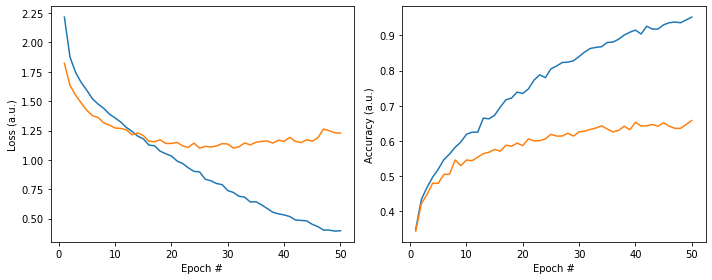

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

x_axis = range(1, EPOCHS + 1)

ax1.plot(x_axis, train_losses, label='train loss')
ax1.plot(x_axis, val_losses, label='validation loss')
ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Loss (a.u.)")

ax2.plot(x_axis, train_accuracies, label='train accuracy')
ax2.plot(x_axis, val_accuracies, label='validation accuracy')
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Accuracy (a.u.)")

fig.tight_layout()


## Make predictions on the test set

In [21]:
def predict(model, input, target, labels):
  model.eval()

  with torch.no_grad():
    predictions = model(input) # a tensor object (1, 10)
    predicted_index = predictions[0].argmax(0)
    predicted = labels[predicted_index]
    expected = labels[target]

  return predicted, expected

sample_idx = 3
inputs, targets = next(iter(dataloader_test))
input, target = inputs[sample_idx], targets[sample_idx]
input.to(device)

predicted, expected = predict(mlp, input, target, labels)

print(f"Predicted: '{predicted}', expected: '{expected}'" )

Predicted: 'jazz', expected: 'jazz'


              precision    recall  f1-score   support

   classical       0.52      0.67      0.58        24
       disco       0.67      1.00      0.80        20
        jazz       0.59      0.73      0.66        26
      reggae       0.71      0.61      0.65        28
        rock       0.42      0.44      0.43        18
     country       0.75      0.68      0.71        31
      hiphop       0.78      0.82      0.80        22
       blues       1.00      0.68      0.81        25
         pop       0.60      0.53      0.56        34
       metal       0.50      0.39      0.44        28

    accuracy                           0.64       256
   macro avg       0.65      0.65      0.64       256
weighted avg       0.66      0.64      0.64       256



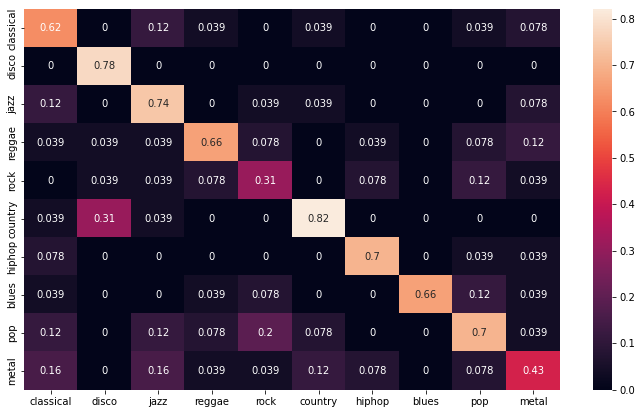

In [22]:
y_pred = []
y_true = []
for input, target in zip(inputs, targets):
  input = input.to(device)
  target = target.to(device)
  predicted, expected = predict(mlp, input, target, labels)
  y_pred.append(predicted)
  y_true.append(expected)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
print(classification_report(y_true, y_pred, target_names=labels))